In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Erwood_BRCA2_HEK293T"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [3]:
scoreset = read_scoreset(dataset_path / "scoreset.csv")
scoreset = scoreset.assign(CHROM=scoreset.CHROM.astype(str),
                           POSITION=scoreset.POSITION.astype(str),
                           REF=scoreset.REF.astype(str),
                           ALT=scoreset.ALT.astype(str))

In [4]:
scoreset.shape

(426, 26)

In [5]:
if scoreset.duplicated(subset=['CHROM',"POSITION",'REF','ALT']).any():
    scoreset_dedup = scoreset.groupby(['CHROM',"POSITION",'REF','ALT']).agg({'score': 'mean'})
else:
    scoreset_dedup = scoreset.set_index(['CHROM',"POSITION",'REF','ALT'])['score']

In [6]:
scoredata = scoreset.set_index(['CHROM',"POSITION",'REF','ALT'])
scoreset = pd.merge(scoreset_dedup,scoredata.loc[:,list(set(scoredata.columns) - {'score','Unadjusted Function Score'})].drop_duplicates(),
                    left_index=True,right_index=True,how='left',validate='one_to_one')

In [7]:
scoreset

score  CADD_phred SPE Classification    exon  \
CHROM POSITION REF ALT                                                    
13    32332641 T   A    1.027413       19.95         Functional  exon10   
                   C    1.007652       10.36         Functional  exon10   
                   G    1.022345       16.29         Functional  exon10   
      32332642 A   C    1.027959         NaN         Functional  exon10   
                   G    1.013021         NaN         Functional  exon10   
...                          ...         ...                ...     ...   
      32362676 T   C    0.992092       15.58          Uncertain  exon17   
                   G    1.090254       15.44         Functional  exon17   
      32362677 C   A    0.997614       25.10         Functional  exon17   
                   G    0.864826       25.00          Uncertain  exon17   
                   T    0.992217       25.60         Functional  exon17   

                        nonsense  select transcript author_transcript  \
CHROM POSITION REF ALT                                                  
13    32332641 T   A       False  Select  NM_000059         NM_000059   
                   C       False  Select  NM_000059         NM_000059   
                   G       False  Select  NM_000059         NM_000059   
      32332642 A   C       False  Select  NM_000059         NM_000059   
                   G       False  Select  NM_000059         NM_000059   
...                          ...     ...        ...               ...   
      32362676 T   C       False  Select  NM_000059         NM_000059   
                   G       False  Select  NM_000059         NM_000059   
      32362677 C   A       False  Select  NM_000059         NM_000059   
                   G       False  Select  NM_000059         NM_000059   
                   T       False  Select  NM_000059         NM_000059   

                       Edited Base  synonymous  \
CHROM POSITION REF ALT                           
13    32332641 T   A             A       False   
                   C             C       False   
                   G             G       False   
      32332642 A   C             C        True   
                   G             G        True   
...                            ...         ...   
      32362676 T   C             C        True   
                   G             G        True   
      32362677 C   A             A       False   
                   G             G       False   
                   T             T       False   

                                                              refseq_id  \
CHROM POSITION REF ALT                                                    
13    32332641 T   A     BRCA2:NM_000059:exon10:c.T1163A:p.V388E:Select   
                   C     BRCA2:NM_000059:exon10:c.T1163C:p.V388A:Select   
                   G     BRCA2:NM_000059:exon10:c.T1163G:p.V388G:Select   
      32332642 A   C     BRCA2:NM_000059:exon10:c.A1164C:p.V388V:Select   
                   G     BRCA2:NM_000059:exon10:c.A1164G:p.V388V:Select   
...                                                                 ...   
      32362676 T   C    BRCA2:NM_000059:exon17:c.T7959C:p.L2653L:Select   
                   G    BRCA2:NM_000059:exon17:c.T7959G:p.L2653L:Select   
      32362677 C   A    BRCA2:NM_000059:exon17:c.C7960A:p.L2654I:Select   
                   G    BRCA2:NM_000059:exon17:c.C7960G:p.L2654V:Select   
                   T    BRCA2:NM_000059:exon17:c.C7960T:p.L2654F:Select   

                       Protein Annotation Wild type Base Clinvar_SIG   CDS  \
CHROM POSITION REF ALT                                                       
13    32332641 T   A                V388E              T         NaN  1163   
                   C                V388A              T         NaN  1163   
                   G                V388G              T         NaN  1163   
      32332642 A   C                V388V              A         NaN  1164   
      

In [8]:
if scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [9]:
clinvar_nuc_summaries = clinvar_df[clinvar_df.index.isin(scoreset.index)].groupby(level=list(range(4)),).apply(mapping_utils.summarize_clinvar_group)

In [10]:
clinvar_nuc_summaries.index.rename(['CHROM',"POSITION",'REF','ALT'],inplace=True)

In [11]:
scoreset_w_clinvar = pd.merge(scoreset,clinvar_nuc_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="many_to_one",
                            suffixes=("","_clinvar"))

In [12]:
scoreset_w_clinvar.shape[0]

423

In [13]:
scoreset_w_clinvar[scoreset_w_clinvar.num_p_lp > 0].shape

(14, 28)

In [14]:
scoreset_w_clinvar[scoreset_w_clinvar.num_b_lb > 0].shape

(58, 28)

# Add gnomAD annotations

In [15]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [16]:
scoreset[scoreset.index.isin(gnomAD_df.index)].shape[0], scoreset.shape[0]

(60, 423)

In [17]:
gnomAD_matches = gnomAD_df[(gnomAD_df.index.isin(scoreset.index)) & \
                            (gnomAD_df.Feature_base.isin(set(Ensembl_transcript_stable_ids).union(set((AUTHOR_TRANSCRIPT,)))))].sort_values(by='AC',ascending=False)

gnomAD_matches_unique = gnomAD_matches[~gnomAD_matches.index.duplicated(keep='first')]

In [18]:
gnomAD_matches_unique.index.rename(['CHROM',"POSITION",'REF','ALT'],inplace=True)

In [19]:
gnomAD_matches_unique.head()

ID  QUAL FILTER   AC        AF  \
CHROM POSITION REF ALT                                            
13    32332644 C   A    rs397507263 -10.0   PASS  299  0.000205   
      32356539 C   T    rs571800995 -10.0   PASS   37  0.000025   
      32362656 C   G    rs778391123 -10.0   PASS   24  0.000016   
      32332644 C   T    rs397507263 -10.0   PASS   19  0.000013   
      32362650 A   G    rs876658889 -10.0   PASS   19  0.000013   

                                                                      vep  \
CHROM POSITION REF ALT                                                      
13    32332644 C   A    A|missense_variant|MODERATE|BRCA2|ENSG00000139...   
      32356539 C   T    T|missense_variant|MODERATE|BRCA2|ENSG00000139...   
      32362656 C   G    G|missense_variant|MODERATE|BRCA2|ENSG00000139...   
      32332644 C   T    T|missense_variant|MODERATE|BRCA2|ENSG00000139...   
      32362650 A   G    G|missense_variant|MODERATE|BRCA2|ENSG00000139...   

                        index Allele       Consequence    IMPACT SYMBOL  \
CHROM POSITION REF ALT                                                    
13    32332644 C   A     4989      A  missense_variant  MODERATE  BRCA2   
      32356539 C   T    13464      T  missense_variant  MODERATE  BRCA2   
      32362656 C   G    15085      G  missense_variant  MODERATE  BRCA2   
      32332644 C   T     4991      T  missense_variant  MODERATE  BRCA2   
      32362650 A   G    15081      G  missense_variant  MODERATE  BRCA2   

                                   Gene Feature_type          Feature  \
CHROM POSITION REF ALT                                                  
13    32332644 C   A    ENSG00000139618   Transcript  ENST00000380152   
      32356539 C   T                675   Transcript      NM_000059.4   
      32362656 C   G                675   Transcript      NM_000059.4   
      32332644 C   T    ENSG00000139618   Transcript  ENST00000380152   
      32362650 A   G                675   Transcript      NM_000059.4   

                               BIOTYPE   EXON  INTRON  \
CHROM POSITION REF ALT                                  
13    32332644 C   A    protein_coding  10/27     NaN   
      32356539 C   T    protein_coding  15/27     NaN   
      32362656 C   G    protein_coding  17/27     NaN   
      32332644 C   T    protein_coding  10/27     NaN   
      32362650 A   G    protein_coding  17/27     NaN   

                                              HGVSc  \
CHROM POSITION REF ALT                                
13    32332644 C   A    ENST00000380152.8:c.1166C>A   
      32356539 C   T          NM_000059.4:c.7547C>T   
      32362656 C   G          NM_000059.4:c.7939C>G   
      32332644 C   T    ENST00000380152.8:c.1166C>T   
      32362650 A   G          NM_000059.4:c.7933A>G   

                                                HGVSp  cDNA_position  \
CHROM POSITION REF ALT                                                 
13    32332644 C   A    ENSP00000369497.3:p.Pro389Gln           1365   
      32356539 C   T         NP_000050.3:p.Ser2516Phe           7746   
      32362656 C   G         NP_000050.3:p.Leu2647Val           8138   
      32332644 C   T    ENSP00000369497.3:p.Pro389Leu           1365   
      32362650 A   G         NP_000050.3:p.Arg2645Gly           8132   

                        CDS_position  Protein_position Amino_acids   Codons  \
CHROM POSITION REF ALT                                                        
13    32332644 C   A            1166               389         P/Q  cCg/cAg   
      32356539 C   T            7547              2516         S/F  tCc/tTc   
      32362656 C   G            7939              2647         L/V  Cta/Gta   
      32332644 C   T            1166               389         P/L  cCg/cTg   
      32362650 A   G            7933              2645         R/G  Aga/Gga   

                        ALLELE_NUM  DISTANCE  STRAND  FLAGS VARIANT_CLASS  \
CHROM POSITION REF ALT                                         

In [20]:
gnomAD_matches.shape, gnomAD_matches_unique.shape

((138, 56), (60, 56))

In [21]:
gnomAD_matches_unique.index.has_duplicates

False

In [22]:
gnomAD_matches_unique.shape, scoreset_w_clinvar.shape

((60, 56), (423, 28))

In [23]:
scoreset_w_clinvar.head()

score  CADD_phred SPE Classification    exon  \
CHROM POSITION REF ALT                                                    
13    32332641 T   A    1.027413       19.95         Functional  exon10   
                   C    1.007652       10.36         Functional  exon10   
                   G    1.022345       16.29         Functional  exon10   
      32332642 A   C    1.027959         NaN         Functional  exon10   
                   G    1.013021         NaN         Functional  exon10   

                        nonsense  select transcript author_transcript  \
CHROM POSITION REF ALT                                                  
13    32332641 T   A       False  Select  NM_000059         NM_000059   
                   C       False  Select  NM_000059         NM_000059   
                   G       False  Select  NM_000059         NM_000059   
      32332642 A   C       False  Select  NM_000059         NM_000059   
                   G       False  Select  NM_000059         NM_000059   

                       Edited Base  synonymous  \
CHROM POSITION REF ALT                           
13    32332641 T   A             A       False   
                   C             C       False   
                   G             G       False   
      32332642 A   C             C        True   
                   G             G        True   

                                                             refseq_id  \
CHROM POSITION REF ALT                                                   
13    32332641 T   A    BRCA2:NM_000059:exon10:c.T1163A:p.V388E:Select   
                   C    BRCA2:NM_000059:exon10:c.T1163C:p.V388A:Select   
                   G    BRCA2:NM_000059:exon10:c.T1163G:p.V388G:Select   
      32332642 A   C    BRCA2:NM_000059:exon10:c.A1164C:p.V388V:Select   
                   G    BRCA2:NM_000059:exon10:c.A1164G:p.V388V:Select   

                       Protein Annotation Wild type Base Clinvar_SIG   CDS  \
CHROM POSITION REF ALT                                                       
13    32332641 T   A                V388E              T         NaN  1163   
                   C                V388A              T         NaN  1163   
                   G                V388G              T         NaN  1163   
      32332642 A   C                V388V              A         NaN  1164   
                   G                V388V              A         NaN  1164   

                           start   hgvs_nuc Consequence     hgvs_pro symbol  \
CHROM POSITION REF ALT                                                        
13    32332641 T   A    32332640  c.1163T>A    missense  p.Val388Glu  BRCA2   
                   C    32332640  c.1163T>C    missense  p.Val388Ala  BRCA2   
                   G    32332640  c.1163T>G    missense  p.Val388Gly  BRCA2   
      32332642 A   C    32332641  c.1164A>C  synonymous  p.Val388Val  BRCA2   
                   G    32332641  c.1164A>G  synonymous  p.Val388Val  BRCA2   

                                                 id  num_p_lp  num_b_lb  \
CHROM POSITION REF ALT                                                    
13    32332641 T   A    chr13-32332640-32332641-T-A       NaN       NaN   
                   C    chr13-32332640-32332641-T-C       NaN       NaN   
                   G    chr13-32332640-32332641-T-G       NaN       NaN   
      32332642 A   C    chr13-32332641-32332642-A-C       NaN       NaN   
                   G    chr13-32332641-32332642-A-G       0.0       1.0   

                        num_conflicting  num_VUS  \
CHROM POSITION REF ALT                             
13    32332641 T   A                NaN      NaN   
                   C                NaN      NaN   
                   G                NaN      NaN   
      32332642 A   C                NaN      NaN   
                   G                0.0      0.0   

                                                   clinvar_names  \
CHROM POSITION REF ALT                                     

In [24]:
scoreset_w_clinvar.index.duplicated().any()

np.False_

In [25]:
gnomAD_matches_unique.head()

ID  QUAL FILTER   AC        AF  \
CHROM POSITION REF ALT                                            
13    32332644 C   A    rs397507263 -10.0   PASS  299  0.000205   
      32356539 C   T    rs571800995 -10.0   PASS   37  0.000025   
      32362656 C   G    rs778391123 -10.0   PASS   24  0.000016   
      32332644 C   T    rs397507263 -10.0   PASS   19  0.000013   
      32362650 A   G    rs876658889 -10.0   PASS   19  0.000013   

                                                                      vep  \
CHROM POSITION REF ALT                                                      
13    32332644 C   A    A|missense_variant|MODERATE|BRCA2|ENSG00000139...   
      32356539 C   T    T|missense_variant|MODERATE|BRCA2|ENSG00000139...   
      32362656 C   G    G|missense_variant|MODERATE|BRCA2|ENSG00000139...   
      32332644 C   T    T|missense_variant|MODERATE|BRCA2|ENSG00000139...   
      32362650 A   G    G|missense_variant|MODERATE|BRCA2|ENSG00000139...   

                        index Allele       Consequence    IMPACT SYMBOL  \
CHROM POSITION REF ALT                                                    
13    32332644 C   A     4989      A  missense_variant  MODERATE  BRCA2   
      32356539 C   T    13464      T  missense_variant  MODERATE  BRCA2   
      32362656 C   G    15085      G  missense_variant  MODERATE  BRCA2   
      32332644 C   T     4991      T  missense_variant  MODERATE  BRCA2   
      32362650 A   G    15081      G  missense_variant  MODERATE  BRCA2   

                                   Gene Feature_type          Feature  \
CHROM POSITION REF ALT                                                  
13    32332644 C   A    ENSG00000139618   Transcript  ENST00000380152   
      32356539 C   T                675   Transcript      NM_000059.4   
      32362656 C   G                675   Transcript      NM_000059.4   
      32332644 C   T    ENSG00000139618   Transcript  ENST00000380152   
      32362650 A   G                675   Transcript      NM_000059.4   

                               BIOTYPE   EXON  INTRON  \
CHROM POSITION REF ALT                                  
13    32332644 C   A    protein_coding  10/27     NaN   
      32356539 C   T    protein_coding  15/27     NaN   
      32362656 C   G    protein_coding  17/27     NaN   
      32332644 C   T    protein_coding  10/27     NaN   
      32362650 A   G    protein_coding  17/27     NaN   

                                              HGVSc  \
CHROM POSITION REF ALT                                
13    32332644 C   A    ENST00000380152.8:c.1166C>A   
      32356539 C   T          NM_000059.4:c.7547C>T   
      32362656 C   G          NM_000059.4:c.7939C>G   
      32332644 C   T    ENST00000380152.8:c.1166C>T   
      32362650 A   G          NM_000059.4:c.7933A>G   

                                                HGVSp  cDNA_position  \
CHROM POSITION REF ALT                                                 
13    32332644 C   A    ENSP00000369497.3:p.Pro389Gln           1365   
      32356539 C   T         NP_000050.3:p.Ser2516Phe           7746   
      32362656 C   G         NP_000050.3:p.Leu2647Val           8138   
      32332644 C   T    ENSP00000369497.3:p.Pro389Leu           1365   
      32362650 A   G         NP_000050.3:p.Arg2645Gly           8132   

                        CDS_position  Protein_position Amino_acids   Codons  \
CHROM POSITION REF ALT                                                        
13    32332644 C   A            1166               389         P/Q  cCg/cAg   
      32356539 C   T            7547              2516         S/F  tCc/tTc   
      32362656 C   G            7939              2647         L/V  Cta/Gta   
      32332644 C   T            1166               389         P/L  cCg/cTg   
      32362650 A   G            7933              2645         R/G  Aga/Gga   

                        ALLELE_NUM  DISTANCE  STRAND  FLAGS VARIANT_CLASS  \
CHROM POSITION REF ALT                                         

In [26]:
gnomAD_matches_unique.index.duplicated().any()

np.False_

In [27]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_matches_unique,
                                        left_index=True,right_index=True,how="left",validate="one_to_one")#.reset_index()

In [28]:
scoreset_processed.shape

(423, 84)

In [29]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [30]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [31]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.AF > 0 and r.spliceAI_scores <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [32]:
INVERT_SCORES = False

sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)


In [33]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 5
B/LB: 58
gnomAD: 60
synonymous: 58


(<Figure size 1200x1200 with 4 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>], dtype=object))

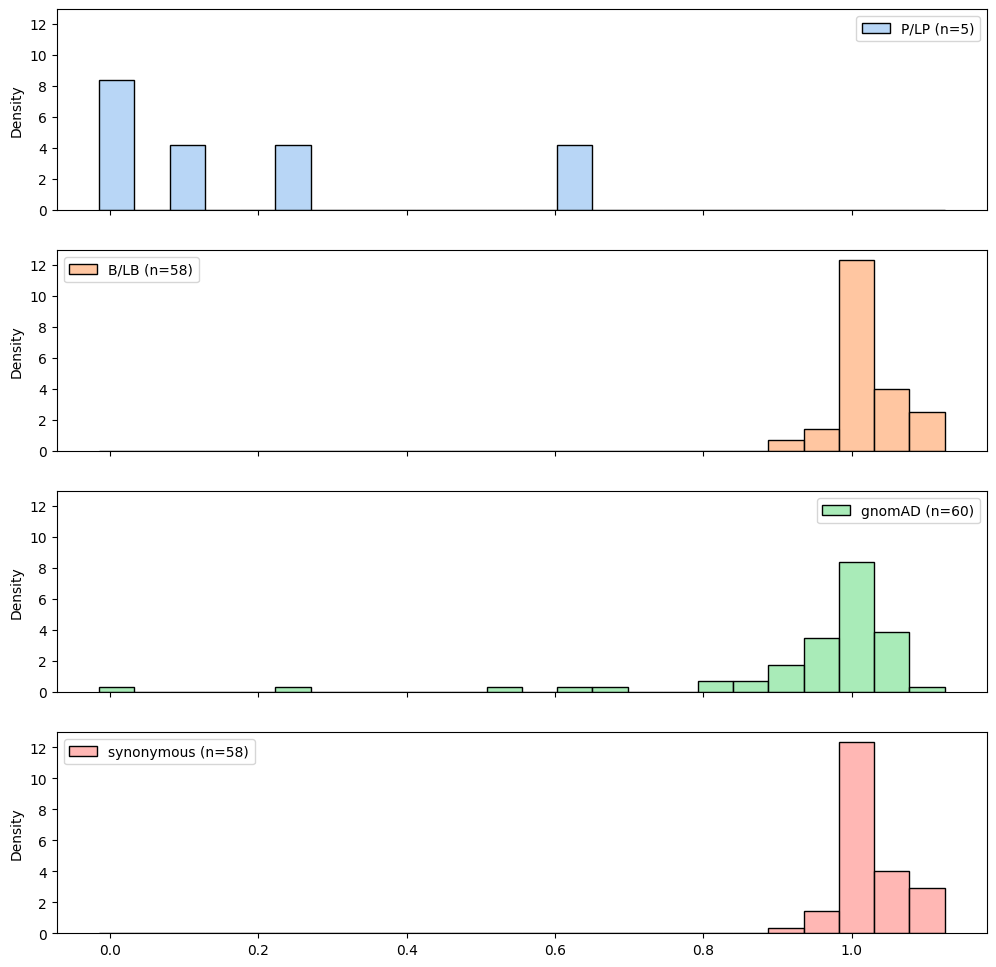

In [34]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [35]:
pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                            *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                            *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                            *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)